- continuation of "Topological feature extraction from graphs"
    - "we saw that geodesic distance is suboptimal, here we elaborate on that"

# Identifying the 'shape' of a network

As we have seen in the tutorial [Topological feature extraction from graphs](https://giotto-ai.github.io/gtda-docs/latest/notebooks/persistent_homology_graphs.html) we can extract topological features from _graphs_. Here, we vaguely define _networks_ as graphs that arose from "real-world data". As "real data" is intrinsicly noisy network properties only make sense if they are robust aginst small perturbations of the network.

This notebook shows how ``giotto-tda`` can be used to generate "meaningful" topological features for networks. To illustrate that networks can indeed capture geometric information we will be using classical topological examples (annulus, cylinder and torus). For a proof of concept that our metric changes smoothly with continuously increasing perturbation we will use the famous Watts-Strogatz model [1].

<div style="text-align: center">
<img src='images/algorithm_of_watts_strogatz_model.png' width="500">
<p style="text-align: center;"> <b>Figure 1:</b> Schematic representation of increasing noise level in the Watts-Strogatz model. <br>
    <a href=https://www.nature.com/articles/30918.>"Watts, Duncan J., and Steven H. Strogatz. 'Collective dynamics of ‘small-world’networks.' Nature (1998)"</a>. </p>
</div>

If you are looking at a static version of this notebook and would like to run its contents, head over to [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/ringity.ipynb).


## Useful references
    [1](https://www.nature.com/articles/30918.)

[THINK OF USEFUL LINKS HERE]

**License: AGPLv3**

# Classes

In [1]:
"""DESCRIPTION."""
# License: GNU AGPLv3

from functools import reduce
from operator import and_
from warnings import warn

import numpy as np
from joblib import Parallel, delayed
from numba import njit
from numpy.ma import masked_invalid
from numpy.ma.core import MaskedArray
from scipy.sparse import csr, csgraph, issparse, isspmatrix_csr, coo_matrix, csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from gtda.base import PlotterMixin
from gtda.utils._docs import adapt_fit_transform_docs
from gtda.utils.validation import check_graph

# -------------------------------------------------------------------
# ---------------------------- FUNCTIONS ----------------------------
# -------------------------------------------------------------------

@njit
def edge_to_single_value(C, u, v):
    F_row = C[u]-C[v]
    ranks = np.empty_like(F_row)
    ranks[np.argsort(F_row)] = np.arange(1, len(F_row)+1)
    return np.sum((2*ranks-1-len(F_row))*F_row)

@njit
def resistance_to_flow(C, row_idx, col_idx):
    """
    [TODO: RETURN MATRIX INSTEAD OF LIST]
    [TODO: DOCSTRING + TESTING]
    """
    return [edge_to_single_value(C, u, v) for (u,v) in zip(row_idx, col_idx)]

def current_flow(A):
    """[TODO: DOCSTRING + TESTING]"""
    
    L = csgraph.laplacian(A).toarray()
    C = np.zeros(L.shape)
    C[1:,1:] = np.linalg.inv(L[1:,1:])
    A_coo = A.tocoo()
    row_idx, col_idx = zip(*((i,j) for (i,j) in zip(A_coo.row, A_coo.col) if i<j))
    values = resistance_to_flow(C, row_idx, col_idx)
    
    return csr_matrix((values+values, (row_idx+col_idx, col_idx+row_idx)))


# -------------------------------------------------------------------
# ----------------------------- Classes -----------------------------
# -------------------------------------------------------------------

# @adapt_fit_transform_docs --> not sure what this is doing..
class GraphCurrentFlowCentrality(BaseEstimator, TransformerMixin):
    """Weighted adjacency matrices arising from current-flow centrality measure
    on graphs.

    For each (unweighted) graph in a collection, this transformer calculates
    the (edge-based) current flow centrality measure for each edge in the graph.
    Given two vertices s and t the st-current flow of an edge (i,j) is
    defined to be the expected number of times a random walker is trespassing
    the edge (i,j) when starting at the node s and stopping at node t. The
    (overall) current-flow is defined as the average of all st-current flows,
    for all possible s and t.

    The graphs are represented by their adjacency matrices which can be dense
    arrays, sparse matrices or masked arrays. The following rules apply:

    - In dense arrays of Boolean type, entries which are ``False`` represent
      absent edges.
    - In dense arrays of integer or float type, zero entries represent edges
      of length 0. Absent edges must be indicated by ``numpy.inf``.
    - In sparse matrices, non-stored values represent absent edges. Explicitly
      stored zero or ``False`` edges represent edges of length 0.

    Parameters
    ----------
    n_jobs : int or None, optional, default: ``None``
        The number of jobs to use for the computation. ``None`` means 1 unless
        in a :obj:`joblib.parallel_backend` context. ``-1`` means using all
        processors.


    Examples [TODO: EXAMPLE]
    --------
    >>> import numpy as np
    >>> from gtda.graphs import TransitionGraph, GraphGeodesicDistance
    >>> X = np.arange(4).reshape(1, -1, 1)
    >>> X_tg = TransitionGraph(func=None).fit_transform(X)
    >>> print(X_tg[0].toarray())
    [[0 1 0 0]
     [0 0 1 0]
     [0 0 0 1]
     [0 0 0 0]]
    >>> X_ggd = GraphGeodesicDistance(directed=False).fit_transform(X_tg)
    >>> print(X_ggd[0])
    [[0. 1. 2. 3.]
     [1. 0. 1. 2.]
     [2. 1. 0. 1.]
     [3. 2. 1. 0.]]

    See also
    --------
    TransitionGraph, KNeighborsGraph, GraphGeodesicDistance

    """

    def __init__(self, n_jobs=None):
        self.n_jobs = n_jobs

    def _current_flow(self, X, i=None):
        if not issparse(X):
            if not isinstance(X, MaskedArray):
                # Convert to a masked array with mask given by positions in
                # which infs or NaNs occur.
                if X.dtype != bool:
                    X = masked_invalid(X)
        elif X.shape[0] != X.shape[1]:
            n_vertices = max(X.shape)
            X = X.copy() if isspmatrix_csr(X) else X.tocsr()
            X.resize(n_vertices, n_vertices)

        return current_flow(X)

    def fit(self, X, y=None):
        """Do nothing and return the estimator unchanged.

        This method is here to implement the usual scikit-learn API and hence
        work in pipelines.

        Parameters
        ----------
        X : list of length n_samples, or ndarray of shape (n_samples, \
            n_vertices, n_vertices)
            Input data: a collection of adjacency matrices of graphs. Each
            adjacency matrix may be a dense or a sparse array.

        y : None
            There is no need for a target in a transformer, yet the pipeline
            API requires this parameter.

        Returns
        -------
        self : object

        """
        X = check_graph(X)

        self._is_fitted = True
        return self

    def transform(self, X, y=None):
        """Compute the lengths of graph shortest paths between any two
        vertices.

        Parameters
        ----------
        X : list of length n_samples, or ndarray of shape (n_samples, \
            n_vertices, n_vertices)
            Input data: a collection of ``n_samples`` adjacency matrices of
            graphs. Each adjacency matrix may be a dense array, a sparse
            matrix, or a masked array.

        y : None
            Ignored.

        Returns
        -------
        Xt : list of length n_samples, or ndarray of shape (n_samples, \
            n_vertices, n_vertices)
            Output collection of dense distance matrices. If the distance
            matrices all have the same shape, a single 3D ndarray is returned.

        """
        check_is_fitted(self, '_is_fitted')
        X = check_graph(X)

        Xt = Parallel(n_jobs=self.n_jobs)(
            delayed(self._current_flow)(x, i=i) for i, x in enumerate(X))

        x0_shape = Xt[0].shape
        if reduce(and_, (x.shape == x0_shape for x in Xt), True):
            Xt = np.asarray(Xt)

        return Xt

In [2]:
class SparseAdjacencyFromigraph(BaseEstimator, TransformerMixin):
    """
    Transforms an igraph.Graph object into a numpy adjacency matrix with giotto-tda conventions. 
    """

    def __init__(self, n_jobs=None):
        self.n_jobs = n_jobs
        
    def _get_numpy_adjacency(self, g):
        A = np.array(g.get_adjacency().data, dtype = float)
        return csr_matrix(A)
    
    def fit(self, X, y=None):
        """Do nothing and return the estimator unchanged.

        This method is here to implement the usual scikit-learn API and hence
        work in pipelines.

        Parameters
        ----------
        X : list of length igraph.Graph objects
            Input data: a collection of graphs.

        y : None
            There is no need for a target in a transformer, yet the pipeline
            API requires this parameter.

        Returns
        -------
        self : object

        """
        return self

    def transform(self, X, y=None):
        """Compute the lengths of graph shortest paths between any two
        vertices.

        Parameters
        ----------
        X : list of length igraph.Graph objects
            Input data: a collection of graphs.

        y : None
            Ignored.

        Returns
        -------
        Xt : list of length numpy adjacency matrix with giotto-tda conventions.

        """

        Xt = Parallel(n_jobs=self.n_jobs)(delayed(self._get_numpy_adjacency)(x) for x in X)

        return Xt

# Setup

In [42]:
import igraph
import numpy as np
import matplotlib.pyplot as plt

from igraph import Graph, plot
from joblib import Parallel, delayed
from gtda.graphs import GraphGeodesicDistance
from gtda.plotting import plot_diagram
from sklearn.base import BaseEstimator, TransformerMixin
from gtda.homology import VietorisRipsPersistence
from IPython.display import SVG, display
from plotly.subplots import make_subplots
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import squareform, pdist
from data.generate_datasets import half_circ, sample_annulus

In [43]:
seed = 11092018

In [44]:
unweighted_steps = [SparseAdjacencyFromigraph(),
                    GraphGeodesicDistance(),
                    VietorisRipsPersistence(metric='precomputed')]

weighted_steps = [SparseAdjacencyFromigraph(),
                  GraphCurrentFlowCentrality(),
                  GraphGeodesicDistance(),
                  VietorisRipsPersistence(metric='precomputed')]

unweighted_pipeline = make_pipeline(*unweighted_steps)
weighted_pipeline = make_pipeline(*weighted_steps)

In [45]:
N = 2**6

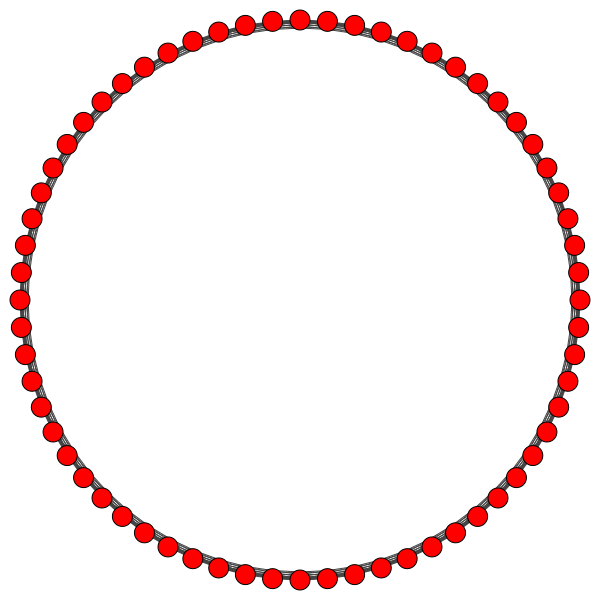

In [51]:
g = Graph.Watts_Strogatz(dim = 1, size = N, nei = 5, p = 0.0)
plot(g, layout = g.layout_circle())

In [67]:
unweighted_dgms = unweighted_pipeline.fit_transform([g])
weighted_dgms = weighted_pipeline.fit_transform([g])

In [68]:
trace1 = plot_diagram(unweighted_dgms[0])
trace2 = plot_diagram(weighted_dgms[0])

In [69]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(trace1.data[0], row=1, col=1)
fig.add_trace(trace1.data[1], row=1, col=1)
fig.add_trace(trace1.data[2], row=1, col=1)

fig.add_trace(trace2.data[0], row=1, col=2)
fig.add_trace(trace2.data[1], row=1, col=2)
fig.add_trace(trace2.data[2], row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Different scales")
fig.show()

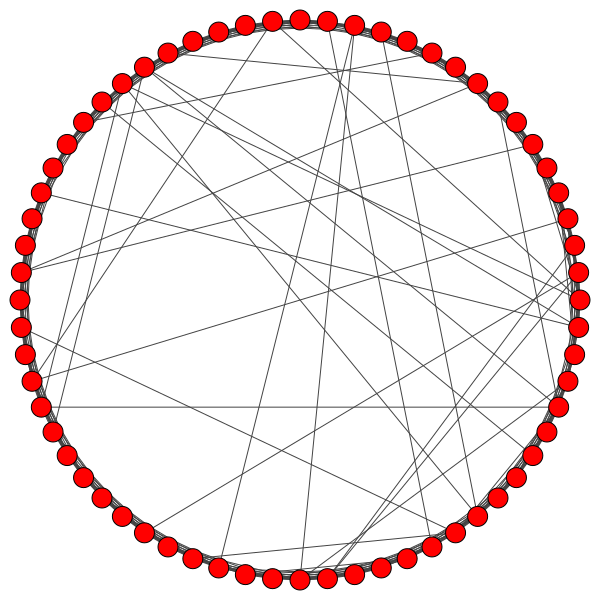

In [70]:
g = Graph.Watts_Strogatz(dim = 1, size = N, nei = 5, p = 0.05)
plot(g, layout = g.layout_circle())

In [71]:
unweighted_dgms = unweighted_pipeline.fit_transform([g])
weighted_dgms = weighted_pipeline.fit_transform([g])

In [72]:
trace1 = plot_diagram(unweighted_dgms[0])
trace2 = plot_diagram(weighted_dgms[0])

In [73]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(trace1.data[0], row=1, col=1)
fig.add_trace(trace1.data[1], row=1, col=1)
fig.add_trace(trace1.data[2], row=1, col=1)

fig.add_trace(trace2.data[0], row=1, col=2)
fig.add_trace(trace2.data[1], row=1, col=2)
fig.add_trace(trace2.data[2], row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Is it a ring, or a sponge?")
fig.show()

# Geometric networks

In [11]:
BLACK = (163/255, 163/255, 163/255)

CEMM_COL1 = (  0/255,  85/255, 100/255)
CEMM_COL2 = (  0/255, 140/255, 160/255)
CEMM_COL3 = ( 64/255, 185/255, 212/255)
CEMM_COL4 = (212/255, 236/255, 242/255)

In [12]:
def plot_nx(G,
            pos = None,
            ax  = None,
            node_colors = None,
            node_alpha  = 0.3,
            edge_colors = None,
            edge_alpha  = 0.2,
            **kwargs):

    if pos is None:
        pos = nx.spring_layout(G)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8));
        fig.patch.set_alpha(0)
    if node_colors is None:
        node_colors = [CEMM_COL1]*nx.number_of_nodes(G)
    if edge_colors is None:
        edge_colors = [CEMM_COL2]*nx.number_of_edges(G)
    nodes = nx.draw_networkx_nodes(G, pos=pos,
                                      alpha=node_alpha,
                                      ax=ax,
                                      node_color=node_colors,
                                      node_size=15,
                                      linewidths=1)

    edges = nx.draw_networkx_edges(G, pos=pos,
                                      alpha=edge_alpha,
                                      ax=ax,
                                      edge_color=edge_colors)
    ax.axis('off');

## Annulus

In [13]:
# sample preprocessing
N = 200
r = 0.5

pts = sample_annulus(N=N, r=r, seed=seed)

x_in  = np.linspace(-r,r, 101)
x1 = np.stack((x_in, -x_in)).flatten()
y1 = np.stack((half_circ(x_in, r),-half_circ(x_in, r))).flatten()

x_out = np.linspace(-1,1, 101)
x2 = np.stack((x_out,-x_out)).flatten()
y2 = np.stack((half_circ(x_out),-half_circ(x_out))).flatten()

x_left  = np.linspace(-1,-r, 101)
x_mid   = np.linspace(-r, r, 101)
x_right = np.linspace( r, 1, 101)

phi = np.linspace(-np.pi,np.pi,101)
x = (r+0.01)*np.cos(phi)
y = (r+0.01)*np.sin(phi)

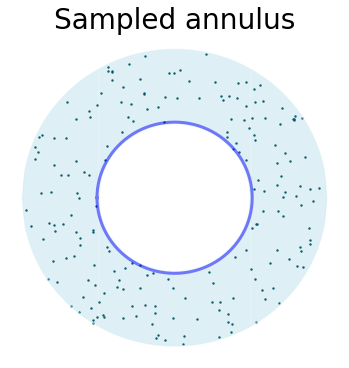

In [14]:
# sampling visual
geo_fig, ax = plt.subplots(figsize=(6,6));
ax.axis('off');

ax.plot(pts[0], pts[1], 'o', markersize=1.5, color=CEMM_COL1, alpha=0.8);

ax.plot(x1, y1, color=CEMM_COL4, alpha=0.5);
ax.plot(x2, y2, color=CEMM_COL4, alpha=0.5);
ax.plot(x, y, color='blue', alpha=0.5, linewidth=3);

ax.set_title('Sampled annulus', fontsize=28);

ax.fill_between(x_left, -half_circ(x_left)  , half_circ(x_left),  alpha=0.75, facecolor=CEMM_COL4, edgecolor="none");
ax.fill_between(x_mid,   half_circ(x_mid, r), half_circ(x_mid),   alpha=0.75, facecolor=CEMM_COL4, edgecolor="none");
ax.fill_between(x_mid,  -half_circ(x_mid, r),-half_circ(x_mid),   alpha=0.75, facecolor=CEMM_COL4, edgecolor="none");
ax.fill_between(x_right, half_circ(x_right) ,-half_circ(x_right), alpha=0.75, facecolor=CEMM_COL4, edgecolor="none");

In [15]:
# network preprocessing
d = 0.5

D = squareform(pdist(np.array(pts).T))
A = np.where(np.abs(D)>d, 0, 1)
np.fill_diagonal(A,0)
graph = igraph.Graph.Adjacency(A.tolist())

In [16]:
fname = "sampled_annulus.svg"
graph.write_svg(fname)
display(SVG(filename=fname))

In [17]:
from scipy.sparse import coo_matrix

In [18]:
# Helper function -- directed circles will be needed later
def make_circle_adjacency(n_vertices, directed=False):
    weights = np.ones(n_vertices)
    rows = np.arange(n_vertices)
    columns = np.arange(1, n_vertices + 1) % n_vertices
    return coo_matrix((weights, (rows, columns)))

n_vertices = 10
undirected_circle = make_circle_adjacency(n_vertices)

In [19]:
VietorisRipsPersistence(metric="precomputed").fit_transform_plot([undirected_circle]);

In [24]:
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
VietorisRipsPersistence(metric="precomputed").fit_transform_plot([A]);

ValueError: zero-size array to reduction operation maximum which has no identity

CALCULATE PERSISTENCE DIAGRAM BASED ON RANDOM-WALK DISTANCE

# Copy from Tutorial starts here

In [1]:
import numpy as np
import ringity as rng
import networkx as nx
import scipy.sparse
from scipy.sparse import csgraph, coo_matrix

from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy

from gtda.graphs.current_flow_centrality import GraphCurrentFlowCentrality, resistance_to_flow
from data.generate_datasets import make_point_clouds

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


n_samples_per_class = 10
point_clouds, labels = make_point_clouds(n_samples_per_class, n_points = 3, noise = 1.5)
point_clouds.shape
print(f"There are {point_clouds.shape[0]} point clouds in {point_clouds.shape[2]} dimensions, "
      f"each with {point_clouds.shape[1]} points.")

There are 30 point clouds in 3 dimensions, each with 9 points.


In [2]:
def symmetrize(A, method='upper'):
    if method == 'upper':
        return A.tocsr() + A.T.tocsr() - A.tocsr().multiply(A.T)
    elif method == 'lower':
        return A.tocsr().multiply(A.T)
    elif method == 'mean':
        return (A.tocsr() + A.T.tocsr()) / 2
    else:
        Exception(f"Method {method} unknown.")
    

### Create dataset

In [3]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
diagrams = VR.fit_transform(point_clouds)
diagrams.shape

(30, 12, 3)

In [4]:
KNN = KNeighborsGraph(n_neighbors=4)
adj_list = KNN.fit_transform(point_clouds)

In [5]:
for (nr, A) in enumerate(adj_list):
    G = nx.from_scipy_sparse_matrix(A)
    if not nx.is_connected(G):
        print(nr)

In [6]:
weight_list = GraphCurrentFlowCentrality().fit_transform(map(symmetrize, adj_list))

In [11]:
weight_list = list(weight_list)

In [10]:
weight_list.shape

(30,)

In [9]:
weight_list[0]

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in COOrdinate format>

In [12]:
D_list = GraphGeodesicDistance().fit_transform(weight_list)

ValueError: csgraph must be lil, csr, or csc format

In [9]:
for A in adj_list:
    L = csgraph.laplacian(symmetrize(A)).toarray()
    C = np.zeros(L.shape)
    C[1:,1:] = np.linalg.inv(L[1:,1:])
    A_coo = A.tocoo()
    row_idx, col_idx = zip(*((i,j) for (i,j) in zip(A_coo.row, A_coo.col) if i<j))
    values = resistance_to_flow(C, row_idx, col_idx)
    T = coo_matrix((values+values, (row_idx+col_idx, col_idx+row_idx)))

In [13]:
len(row_idx + col_idx), len(values)

(42, 21)

In [25]:
row_idx, col_idx = zip(*((i,j) 
                        for (i,j) in zip(A_coo.row, A_coo.col) if i<j))

In [26]:
row_idx

(0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 6, 7)

In [21]:
col_idx

array([8, 1, 2, 6, 8, 2, 6, 8, 5, 5, 4, 6, 8, 5, 8, 6, 8, 8, 8],
      dtype=int32)

In [22]:
values

[3.2418079096045185,
 2.666666666666668,
 4.051232665639445,
 3.3572162300975856,
 3.2418079096045203,
 4.051232665639446,
 3.3572162300975865,
 2.814483821263482,
 3.7950693374422193,
 3.2989214175654857,
 3.838058551617875,
 4.333590138674885,
 3.6557781201849,
 3.306471494607088,
 3.772727272727273,
 3.9992295839753473,
 3.195069337442219,
 2.5594761171032356,
 3.7727272727272725]

In [74]:
B = symmetrize(A, method='lower').toarray()
C = symmetrize(A, method='mean').toarray()
D = symmetrize(A, method='upper').toarray()

In [75]:
B == B.T

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [76]:
C == C.T

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [77]:
D == D.T

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [78]:
B <= C

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [79]:
C <= D

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [82]:
C == B

array([[ True,  True, False,  True,  True, False, False,  True,  True],
       [ True,  True,  True, False, False,  True,  True,  True,  True],
       [False,  True,  True,  True, False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True, False],
       [ True, False, False,  True,  True, False,  True, False,  True],
       [False,  True,  True,  True, False,  True,  True, False,  True],
       [False,  True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True, False, False, False,  True,  True],
       [ True,  True,  True, False,  True,  True, False,  True,  True]])

In [67]:
G = nx.from_scipy_sparse_matrix(A)

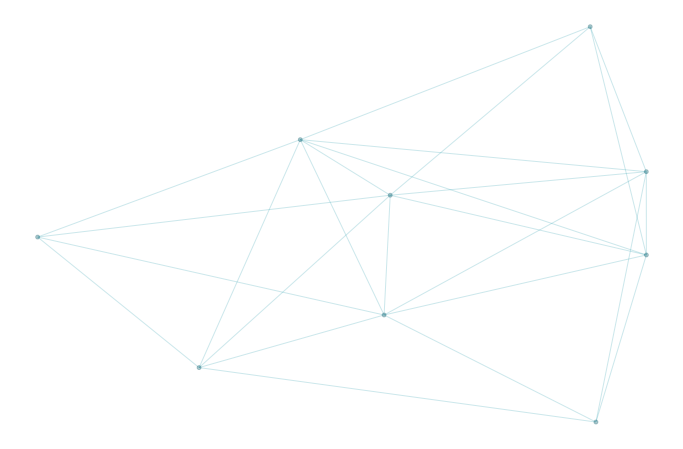

In [68]:
rng.plot_nx(G)

In [28]:
np.linalg.matrix_rank(L)

99

In [42]:
i = 0
plot_diagram(diagrams[i])

### Step by step

In [43]:
PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(features, labels)
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_valid, y_valid)

0.875

### Pipeline

In [45]:
steps = [VietorisRipsPersistence(homology_dimensions=[0, 1, 2]),
         PersistenceEntropy(),
         RandomForestClassifier()]
pipeline = make_pipeline(*steps)

pcs_train, pcs_valid, labels_train, labels_valid = train_test_split(point_clouds, labels)

pipeline.fit(pcs_train, labels_train)

pipeline.score(pcs_valid, labels_valid)

0.5

# Template starts here

## Load the MNIST dataset

To get started, let's fetch the MNIST dataset using one of ``scikit-learn``'s helper functions:

In [ ]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

By looking at the shapes of these arrays

In [ ]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

we see that there are 70,000 images, where each image has 784 features that represent pixel intensity. Let's reshape the feature vector to a 28x28 array and visualise one of the "8" digits using ``giotto-tda``'s plotting API:

In [ ]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "8")[0]
img8 = X[im8_idx].reshape(28, 28)
plot_heatmap(img8)

### Create train and test sets

For this example, we will work with a small subset of images – to run a full-blown analysis simply change the values of ``train_size`` and ``test_size`` below:

In [ ]:
from sklearn.model_selection import train_test_split

train_size, test_size = 60, 10

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

## From pixels to topological features

As shown in the figure below, several steps are required to extract topological features from an image. Since our images are made of pixels, it is convenient to use filtrations of [_cubical complexes_](https://giotto-ai.github.io/gtda-docs/latest/theory/glossary.html#cubical-complex) instead of simplicial ones. Let's go through each of these steps for a single "8" digit using ``giotto-tda``!

<div style="text-align: center">
<img src='images/example_pipeline_images.png' width='600'>
<p style="text-align: center;"> <b>Figure 2:</b> An example of a topological feature extraction pipeline. Figure reference: <a href="https://arxiv.org/abs/1910.08345">arXiv:1910.08345</a>. </p>
</div>

### Binarize the image

In ``giotto-tda``, filtrations of cubical complexes are built from _binary images_ consisting of only black and white pixels. We can convert our greyscale image to binary by applying a threshold on each pixel value via the ``Binarizer`` transformer:

In [ ]:
from gtda.images import Binarizer

# Pick out index of first 8 image
im8_idx = np.flatnonzero(y_train == "8")[0]
# Reshape to (n_samples, n_pixels_x, n_pixels_y) format
im8 = X_train[im8_idx][None, :, :]

binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

### From binary image to filtration

Now that we have a binary image $\mathcal{B}$ of our "8" digit, we can build a wide variety of different filtrations – see the ``giotto-tda`` [docs](https://giotto-ai.github.io/gtda-docs/latest/modules/images.html#filtrations) for a full list. For our example, we'll use the _radial filtration_ $\mathcal{R}$, which assigns to each pixel $p$ a value corresponding to its distance from a predefined center $c$ of the image

$$ \mathcal{R}(p) = \left\{ \begin{array}{cl} 
\lVert c - p \rVert_2 &\mbox{if } \mathcal{B}(p)=1 \\ 
\mathcal{R}_\infty &\mbox{if } \mathcal{B}(p)=0 
\end{array} \right. $$

where $\mathcal{R}_\infty$ is the distance of the pixel that is furthest from $c$. To reproduce the filtered image from the MNIST [article](https://arxiv.org/abs/1910.08345), we'll pick $c = (20,6)$:

In [ ]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale="jet")

We can see from the resulting plot that we've effectively transformed our binary image into a greyscale one, where the pixel values increase as we move from the upper-right to bottom-left of the image! These pixel values can be used to define a filtration of cubical complexes $\{K_i\}_{i\in \mathrm{Im}(I)}$, where $K_i$ contains all pixels with value less than the $i$th smallest pixel value in the greyscale image. In other words, $K_i$ is the $i$th sublevel set of the image's cubical complex $K$.

### From filtration to persistence diagram

Given a greyscale filtration it is straightforward to calculate the corresponding persistence diagram. In ``giotto-tda`` we make use of the ``CubicalPersistence`` transformer which is the cubical analogue to simplicial transformers like ``VietorisRipsPersistence``:

In [ ]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

It works! We can clearly see two persistent $H_1$ generators corresponding to the loops in the digit "8", along with a single $H_0$ generator corresponding to the connected components. 

As a postprocessing step, it is often convenient to rescale the persistence diagrams which can be achieved in ``giotto-tda`` as follows:

In [ ]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

### From persistence diagram to representation

The final step is to define a vectorial representation of the persistence diagram that can be used to obtain machine learning features. Following our example from Figure 2, we convolve our persistence diagram with a Gaussian kernel and symmetrize along the main diagonal, a procedure achieved via the [``HeatKernel``](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.HeatKernel.html#gtda.diagrams.HeatKernel) transformer:

In [ ]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
im8_heat = heat.fit_transform(im8_scaled)

# Visualise the heat kernel for H1
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')

### Combining all steps as a single pipeline

We've now seen how each step in Figure 2 is implemented in ``giotto-tda`` – let's combine them as a single ``scikit-learn`` pipeline:

In [ ]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
    ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)

In [ ]:
im8_pipeline = heat_pipeline.fit_transform(im8)
im8_pipeline

In the final step we've used the [``Amplitude``](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/features/gtda.diagrams.Amplitude.html) transformer to "vectorize" the persistence diagram via the heat kernel method above. In our example, this produces a vector of amplitudes $\mathbf{a} = (a_0, a_1)$ where each amplitude $a_i$ corresponds to a given homology dimension in the persistence diagram. By extracting these feature vectors from each image, we can feed them into a machine learning classifier – let's tackle this in the next section!

## Building a full-blown feature extraction pipeline

Now that we've seen how to extract topological features for a single image, let's make it more realistic and extract a wide variety of features over the whole training set. The resulting pipeline resembles the figure below, where different filtrations and vectorizations of persistence diagrams can be concatenated to produce informative feature vectors.

<div style="text-align: center">
<img src='images/diagram_pipeline_images.png' width='500'>
<p style="text-align: center;"> <b>Figure 3:</b> A full-blown topological feature extraction pipeline </p>
</div>

To keep things simple, we'll augment our radial filtration with a _height filtration_ $\mathcal{H}$, defined by choosing a unit vector $v \in \mathbb{R}^2$ in some _direction_ and assigning values $\mathcal{H}(p) = \langle p, v \rangle$ based on the distance of $p$ to the hyperplane defined by $v$. Following the article by Garin and Tauzin, we'll pick a uniform set of directions and centers for our filtrations as shown in the figure below.

<div style="text-align: center">
<img src='images/directions_and_centers.png' width='250'>
</div>

We'll also generate features from persistence diagrams by using [_persistence entropy_](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/features/gtda.diagrams.PersistenceEntropy.html) and a broad set of amplitudes. Putting it all together yields the following pipeline

In [ ]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

which can be visualised using ``scikit-learn``'s nifty [HTML feature](https://scikit-learn.org/stable/modules/compose.html#visualizing-composite-estimators):

In [ ]:
from sklearn import set_config
set_config(display='diagram')  

tda_union

It's now a simple matter to run the whole pipeline:

In [ ]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

## Training a classifier

We see we have generated $(8 + 9) \times 2 \times 14 = 476$ topological features per image! In general, some of these features will be highly correlated and a feature selection procedure could be used to select the most informative ones. Nevertheless, let's train a Random Forest classifier on our training set to see what kind of performance we can get:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
rf.score(X_test_tda, y_test)

For such a small dataset, this accuracy is not too bad but accuracies above 96% can be achieved by training on the full MNIST dataset together with feature selection strategies.

## Using hyperparameter search with topological pipelines 

In the above pipeline, we can think of our choices for the directions and centers of the filtrations as hyperparameter. To wrap up our analysis, let's see how we can run a hyperparameter search over the directions of the height filtration. We'll use a simplified pipeline to show the main steps, but note that a realistic application would involve running the search over a pipeline like the one in the previous section.

As usual, we define our pipeline in terms of topological transformers and an estimator as the final step:

In [ ]:
height_pipeline = Pipeline([
    ('binarizer', Binarizer(threshold=0.4)),
    ('filtration', HeightFiltration()),
    ('diagram', CubicalPersistence()),
    ('feature', PersistenceEntropy(nan_fill_value=-1)),
    ('classifier', RandomForestClassifier(random_state=42))
])

Next we can search for the best combination of directions, homology dimensions, and number of trees in our Random Forest as follows:

In [ ]:
from sklearn.model_selection import GridSearchCV

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
homology_dimensions_list = [[0], [1]]
n_estimators_list = [500, 1000, 2000]

param_grid = {
    "filtration__direction": [np.array(direction) for direction in direction_list],
    "diagram__homology_dimensions": [
        homology_dimensions for homology_dimensions in homology_dimensions_list
    ],
    "classifier__n_estimators": [n_estimators for n_estimators in n_estimators_list],
}

grid_search = GridSearchCV(
    estimator=height_pipeline, param_grid=param_grid, cv=3, n_jobs=-1
)

grid_search.fit(X_train, y_train)

By looking at the best hyperparameters

In [ ]:
grid_search.best_params_

we see that the direction [1, 0] with homology dimension 0 produces the best features. By comparing say a "6" and "9" digit, can you think of a reason why this might be the case?